# Détection de thématiques avec LDA (Latend Dirichlet Allocation).

Dans ce TP, nous allons mettre application une technique assez simple permettant de détecter les thématiques abordées dans un corpus de textes. Cette technique est largement utilisée pour l'exploration des données textuelles, comme une phase d'analyse des données ; mais également à des fins prédicitives, pour le clustering des texes (commentaires, news, etc.).

In [4]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 39.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [5]:
!pip install pyLDAvis==2.1.2

In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy
import fr_core_news_md
import gensim
import pyLDAvis.gensim
from string import punctuation
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from pylab import rcParams
from collections import Counter
from wordcloud import WordCloud
import warnings

ModuleNotFoundError: No module named 'spacy'

In [ ]:
warnings.filterwarnings('ignore')

## Chargement des données.

Les données que nous allons utiliser proviennent du monde réel. Elles consistent en de brèves de descriptions de projets réalisés par une entreprise (Colonne "Titre projet").


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Projets.xlsx to Projets.xlsx


In [ ]:
df_data = pd.read_excel('Projets.xlsx')
df_data.head()

,Pays,Titre projet
0,FRANCE,Réalisation d'un guide des savoir-faire en arb...
1,FRANCE,Prospection foncière sur la gestion de matéria...
2,FRANCE,Projet PEPITE
3,FRANCE,Adaptation de Leptospheria maculans 'brassicac...
4,FRANCE,Développement et qualification de process de f...


## Prétraitement des donnéees.

Le prétraitement des données est une étape très importante pour tout projet NLP ; elle doit donc être menée précautionneusement et d'une manière spécifique à la fois aux données et au cas d'usage visé, car elle peut déterminer l'issue d'un projet.

Le prétraitement effectué n'est pas exhaustif et consiste à supprimer certains caractères spéciaux et stop words. Les étudiants sont encouragés à tester différents prétraitements et observer l'évolution des thématiques en fonction de cela.

In [ ]:
# Chargement du modèle de langue. Il permet en particulier de reconnaitre les verbes, noms, etc. dans une phrase. Le modèle chargé embarque
# aussi une liste de stop words par défaut.
nlp = fr_core_news_md.load()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
# Suppression de certains caractères spéciaux.
def clean(text):
    new = text.replace('\n', '')
    new = new.replace('\r', '')
    new = new.replace('.', '')
    new = new.replace (',', '')
    new = new.replace(':', '')
    new = new.replace('?', '')
    new = new.replace('-', '')
    return new

In [ ]:
# Cette fonction renvoie la liste des tokens sans les stop words.
def stop_words(tokens):
    stop_words = nlp.Defaults.stop_words
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    return tokens_without_sw


In [ ]:
# Tokénisation des phrases.
def tokenize(sentence):
    doc = nlp(sentence)
    return doc

In [ ]:
# Application du prétraitement : suppression de certains caractère spéciaux, des stop words et mise en minuscules des tokens.
def process(texts):
    add_stop_words = ['expertise', 'analyse']
    list_list_tokens = []
    for row in texts:
        if row == row:
            text = clean(row)
            tokens = tokenize(text)
            tokens_lemm = [token.lemma_ for token in tokens]
            tokens_lower = [token.lower() for token in tokens_lemm]
            tokens_without_sw = stop_words(tokens_lower)
            final_tokens = [token for token in tokens_without_sw if token not in add_stop_words]
            list_list_tokens.append(final_tokens)
    return list_list_tokens

## Analyse des données

In [ ]:
# Récupération des mots clés pour chaque description de projet. Il est à noter que cette fonction n'intervient pas dans la détection de thématiques
# en tant que telle. Elle permet simplement d'analyser le corpus.
def get_keywords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result

In [ ]:
# Conter la fréquence des différents mots pour avoir une idée du contenu du corpus.
def count_words(list_list):
    vocab_dict = {}
    for lis in list_list:
        for token in lis:
            if token in vocab_dict.keys():
                vocab_dict[token] += 1
            else:
                vocab_dict[token] = 1
    return vocab_dict

In [ ]:
token_list = process(df_data['Titre projet'])
dict_words = count_words(token_list)
count = Counter(dict_words)
list_sorted = count.most_common()
list_sorted
#list_sorted.pop(4)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

[('_', 127),
 (' ', 66),
 ('mise', 33),
 ('projet', 31),
 ('place', 31),
 ('stratégie', 27),
 ('développement', 26),
 ('optimisation', 26),
 ('agricole', 24),
 ('x000d', 22),
 ('marché', 22),
 ('culture', 21),
 ('système', 20),
 ('produit', 19),
 ('étude', 18),
 ('gestion', 16),
 ('agriculture', 16),
 ('etude', 15),
 ('élevage', 15),
 ('of', 15),
 ('exploitation', 14),
 ('mettre', 14),
 ('(', 14),
 ('"', 13),
 ('marketing', 13),
 ('production', 13),
 ('filière', 13),
 ('accompagner', 12),
 ('création', 11),
 ('outil', 11),
 ('performance', 11),
 ('qualité', 11),
 ('développer', 11),
 ('normandie', 11),
 ('the', 11),
 ('laitier', 10),
 ('entreprise', 10),
 ('alimentation', 10),
 ('pi', 10),
 ('alimentaire', 10),
 ('commercial', 10),
 ('impact', 9),
 ('stage', 9),
 ('territoire', 9),
 ('durable', 9),
 ('local', 9),
 ('répondre', 8),
 ('processus', 8),
 ('communication', 8),
 (')', 8),
 ('and', 8),
 ('région', 8),
 ('changement', 8),
 ('climatique', 8),
 ('agriculteur', 8),
 ('coopérative

In [ ]:
get_keywords(df_data['Titre projet'][1])

['prospection',
 'foncière',
 'gestion',
 'matériaux',
 'inertes',
 'recherche',
 'sites',
 'favorables',
 'opérations',
 'recyclage',
 'stockage',
 'déchets',
 'inertes._x000d']

In [ ]:
data = {'word' : [item[0] for item in list_sorted], 'freq' : [item[1] for item in list_sorted]}
df_words = pd.DataFrame(data)
df_words[:10]

,word,freq
0,_,127
1,,66
2,mise,33
3,projet,31
4,place,31
5,stratégie,27
6,développement,26
7,optimisation,26
8,agricole,24
9,x000d,22


<Figure size 432x288 with 0 Axes>

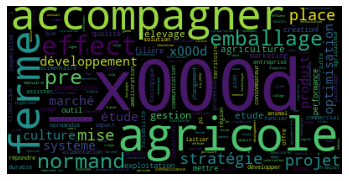

<Figure size 432x288 with 0 Axes>

In [ ]:
text = " ".join([(k + " ") for k,v in list_sorted])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()

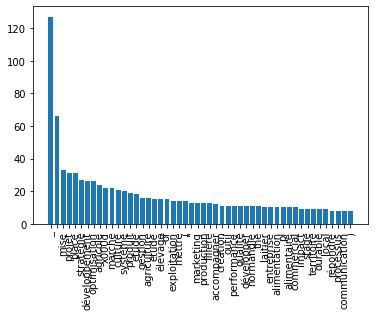

In [ ]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20, 10)
#df_words[:50].plot.bar()
ax.bar(df_words.word[:50].tolist(), df_words.freq[:50].tolist())
plt.xticks(rotation = 90)
plt.show()

## Détection des thématiques.

Dans cette section, nous allons mettre en oeuvre l'algorithme LDA pour la détection des thématiques. Celui-ci est fourni par la librairie "Gensim" et nécessite deux éléments en entrée :


*   Un dictionnaire du vocabulaire contenu dans tout  le corpus de textes, indexé par des nombre entier.
*   Le corpus de tous les textes (liste de listes contenant les tokens de chaque texte).

Il faut par ailleurs spécifier à l'lgorithme le nombre de thématiques désiré (num_topics).

In [ ]:
dictionary = corpora.Dictionary(token_list)
corpus = [dictionary.doc2bow(text) for text in token_list]

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes=20)
cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
print(cm.get_coherence())

-14.647286676062405


Il est possible de déterminer le nombre de thématiques d'une manière automatique en maximisant une métrique ("coherence"). Il suffit alors d'itérer l'algorithme LDA sur différents nombre de thématiques (ici de 2 à 9) et de sélectionner ensuite le nombre de thématiques ayant le plus grand score de cohérence alors que la courbe de cohérence est en phase ascendante.

In [ ]:
coherence = []
for num in range(2, 10, 1):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num, id2word = dictionary, passes=20)
    cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
    coherence.append(cm.get_coherence())

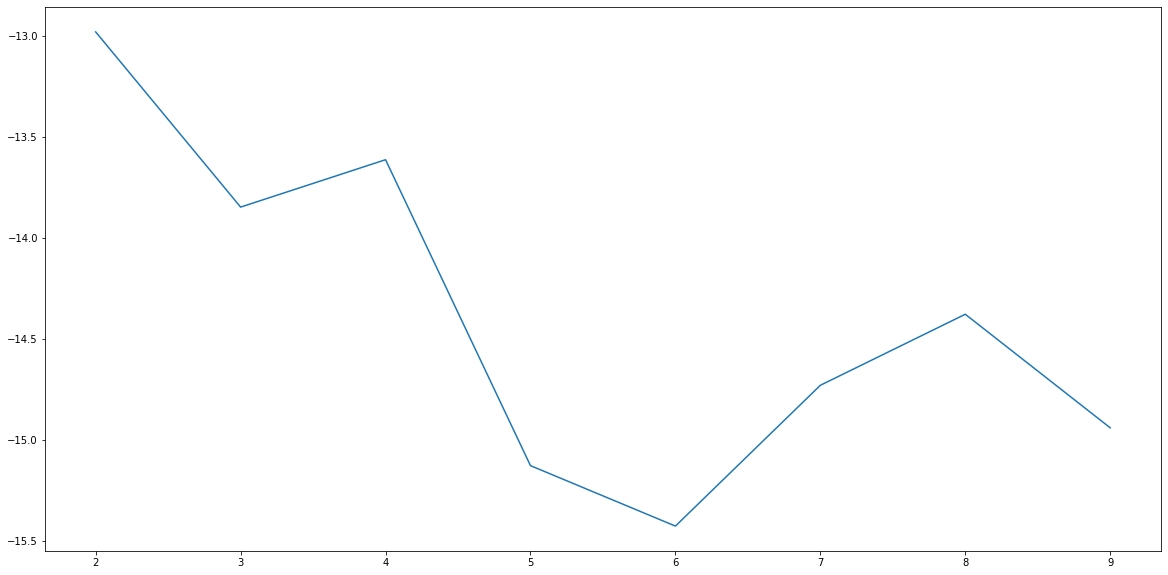

In [ ]:
x = range(2, 10, 1)
plt.plot(x, coherence)
plt.show()

On peut ensuite exécuter le LDA pour le nombre de thématiques optimal, déterminé automatiquement ou choisi d'une manière ad hoc.

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes=20)

La librairie "PyLDAvis" permet de visualiser les thématiques ainsi que les mots clés associés à chacune d'elle d'une manière intuitive.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary = ldamodel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.154813  0.018409       1        1  39.688128
3     -0.048141 -0.111067       2        1  23.747672
1     -0.079697  0.108064       3        1  20.613067
2     -0.026975 -0.015406       4        1  15.951132, topic_info=             Term       Freq      Total Category  logprob  loglift
120         place  24.000000  24.000000  Default  30.0000  30.0000
84          etude  11.000000  11.000000  Default  29.0000  29.0000
166   agriculture  11.000000  11.000000  Default  28.0000  28.0000
96        laitier   7.000000   7.000000  Default  27.0000  27.0000
49           mise  25.000000  25.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
258      agricole   2.796925  18.962800   Topic4  -5.1066  -0.0783
701   agriculteur   1.977454   6.346964   Topic4  -5.4533   0.6695
0               _   3.547290  96.210854   Topic4  -4.8689  -1.4647
128  optimisation   2.132318  19.440461   Topic4  -5.3779  -0.3745
270     stratégie   2.145501  21.185518   Topic4  -5.3717  -0.4543

[259 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
81        1  0.462933         
81        2  0.362296         
81        3  0.100638         
81        4  0.080510         
61        1  0.570942        "
...     ...       ...      ...
682       2  0.928047  énergie
729       4  0.492232     étud
608       1  0.697898    étude
608       3  0.279159    étude
608       4  0.069790    étude

[331 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [77]:
#zdzdzdzdzdz